### Cycle Gan - [notebook](https://github.com/fastai/course-v3/blob/master/nbs/dl2/cyclegan.ipynb), [notes](https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-12-215dfbf04a94)

Convert photos of one type of object into another type of object eg. turn photos of horses into the same photo with zebras, and vice versa.

**Todos**
*   Add proper Arch and App as per template
*   Fetch data using Databundle
*   Use DTR
*   Display batch and results with display_data
*   Do Predictions
*   Run with more epochs and see what loss, metrics, results we get
*   A
*   D
*   C
*   C
*   C
*   C
*   D
*   S
*   M
*   item




















### TEMP - Get Data with Fastai code

In [0]:
from fastai.vision import *

One-time download, uncomment the next cells to get the data.

In [0]:
path = Config().data_path()

In [0]:
! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -P {path}
! unzip -q -n {path}/horse2zebra.zip -d {path}
! rm {path}/horse2zebra.zip

--2020-03-18 09:42:30--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘/root/.fastai/data/horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  83.0MB/s    in 1.3s    

2020-03-18 09:42:31 (83.0 MB/s) - ‘/root/.fastai/data/horse2zebra.zip’ saved [116867962/116867962]



In [0]:
path = Config().data_path()/'horse2zebra'
path.ls()

[PosixPath('/root/.fastai/data/horse2zebra/trainA'),
 PosixPath('/root/.fastai/data/horse2zebra/testA'),
 PosixPath('/root/.fastai/data/horse2zebra/testB'),
 PosixPath('/root/.fastai/data/horse2zebra/trainB')]

See [this tutorial](https://docs.fast.ai/tutorial.itemlist.html) for a detailed walkthrough of how/why this custom `ItemList` was created.

In [0]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[-1+2*img1.data,-1+2*img2.data]
    
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        return self
    
    def to_one(self): return Image(0.5+torch.cat(self.data,2)/2)

In [0]:
class TargetTupleList(ItemList):
    def reconstruct(self, t:Tensor): 
        if len(t.size()) == 0: return t
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

In [0]:
class ImageTupleList(ImageList):
    _label_cls=TargetTupleList
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [0]:
data = (ImageTupleList.from_folders(path, 'trainA', 'trainB')
                      .split_none()
                      .label_empty()
                      .transform(get_transforms(), size=128)
                      .databunch(bs=1))

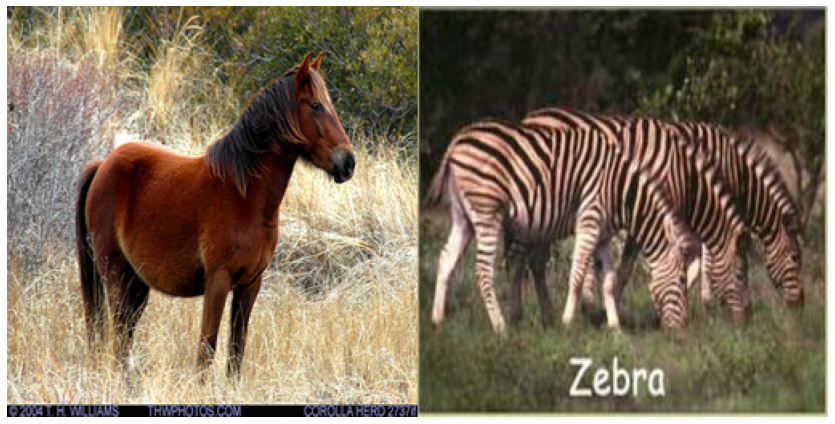

In [0]:
data.show_batch(rows=2)

### Import KD Libraries

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import IPython.core.debugger as db
from functools import partial
from pathlib import Path
import torch
import torch.nn.functional as F
from torch import tensor, nn

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

In [0]:
from nb_data import *
from nb_training import *
from nb_optimiser import *

### Cycle Gan

In [0]:
#----------------------------------------------------
# Create a Resnet module with two Conv blocks
#----------------------------------------------------
class ResnetBlock(nn.Module):
  def __init__(self, ch_in, pad_mode):
    super().__init__()
    assert pad_mode in ['zeros', 'reflection', 'replication'], f'padding {pad_mode} not implemented.'

    # Create the two Conv blocks and wrap them in a Sequential module
    layers = ArchCycleGAN.create_conv(ch_in, ch_in, pad_mode)
    layers += ArchCycleGAN.create_conv(ch_in, ch_in, pad_mode, add_relu=False)
    self.conv_block = nn.Sequential(*layers)

  #----------------------------------------------------
  # Process the input through the Conv layers and then, since we're a Resnet, we
  # also add the input to the output.
  #----------------------------------------------------
  def forward(self, x):
    return x + self.conv_block(x)

#----------------------------------------------------
# Top-level Cycle GAN module with two Generators (A->B and B->A) and two Discriminators (A->B and B->A)
#----------------------------------------------------
class CycleGAN(nn.Module):
  def __init__(self, ch_in, ch_out, n_features, n_disc, n_resnet):
    super().__init__()
    # Naming convention is that '_AB' means (A->B)
    self.D_AB = ArchCycleGAN._create_discriminator(ch_in, n_features, n_layers=n_disc)
    self.D_BA = ArchCycleGAN._create_discriminator(ch_in, n_features, n_layers=n_disc)
    self.G_AB = ArchCycleGAN._create_generator(ch_in, ch_out, n_features, n_resnet)
    self.G_BA = ArchCycleGAN._create_generator(ch_in, ch_out, n_features, n_resnet)

  #----------------------------------------------------
  # We get a pair of images, 'A' and 'B", as input. We generate corresponding
  # fake images 'B' and 'A' respectively by passing them through the generator
  #----------------------------------------------------
  def forward(self, real_A_B):
    # Save off the real input images so we can use them in the loss function
    self.real_A, self.real_B = real_A_B
    fake_A, fake_B = self.G_BA(self.real_B), self.G_AB(self.real_A)
    return [fake_A, fake_B]

#----------------------------------------------------
# Create the Cycle GAN architecture
#----------------------------------------------------
class ArchCycleGAN ():
  # Define the model
  def __init__(self, ch_in, ch_out, n_features, n_disc, n_resnet):
    self.arch = CycleGAN(ch_in, ch_out, n_features, n_disc, n_resnet)

  @staticmethod
  #----------------------------------------------------
  # Create the Generator
  # It has three components (viz. an Encoder, a Transformer and a Decoder) wrapped in
  # a Sequential module
  #----------------------------------------------------
  def _create_generator(ch_in, ch_out, n_features, n_resnet):
    encoder_ch_out, layers = ArchCycleGAN._create_gen_encoder(ch_in, n_features)
    layers += ArchCycleGAN._create_gen_transformer(encoder_ch_out, n_resnet)
    layers += ArchCycleGAN._create_gen_decoder(encoder_ch_out, ch_out)

    generator = nn.Sequential(*layers)
    return generator 

  @staticmethod
  #----------------------------------------------------
  # Create the Discriminator
  # It consists of a series of Conv blocks, with a final Conv block at the end to
  # help classify the image as real or fake.
  #----------------------------------------------------
  def _create_discriminator(first_ch_in, first_ch_out, n_layers):
    next_ch_in, next_ch_out = first_ch_in, first_ch_out

    # Create multiple Conv blocks with Leaky Relu. Be careful that we match the 'channels in' with
    # the 'channels out' of the previous block

    # Create a Conv block with Leaky Relu
    layers = ArchCycleGAN.create_conv_leaky(next_ch_in, next_ch_out, kernel_sz=4, stride=2, pad_sz=1, add_norm=False)

    # Create some Conv blocks with Leaky Relu
    for i in range(n_layers-1):
      next_ch_in = next_ch_out
      next_ch_out = 2 * next_ch_in if i <= 3 else next_ch_in
      layers += ArchCycleGAN.create_conv_leaky(next_ch_in, next_ch_out, kernel_sz=4, stride=2, pad_sz=1, add_norm=True)
        
    # Create another Conv block with Leaky Relu
    next_ch_in = next_ch_out
    next_ch_out = 2 * next_ch_in if n_layers <=3 else next_ch_in
    layers += ArchCycleGAN.create_conv_leaky(next_ch_in, next_ch_out, kernel_sz=4, stride=1, pad_sz=1, add_norm=True)

    # The final Conv block produces a 1D output to decide between a real and fake image
    final_conv = nn.Conv2d(next_ch_out, 1, kernel_size=4, stride=1, padding=1)
    layers.append(final_conv)

    discriminator = nn.Sequential(*layers)
    return discriminator

  @staticmethod
  #----------------------------------------------------
  # Create the Generator's Encoder component, which consists of a series of Conv blocks
  # The Encoder steps down the image size as it extracts feature vectors
  #----------------------------------------------------
  def _create_gen_encoder(first_ch_in, first_ch_out):
    next_ch_in, next_ch_out = first_ch_in, first_ch_out
    encoder_layers = ArchCycleGAN.create_conv(next_ch_in, next_ch_out, pad_mode='reflection', kernel_sz=7, pad_sz=3)
    for i in range(2):
      next_ch_in = next_ch_out
      next_ch_out = next_ch_in * 2
      encoder_layers += ArchCycleGAN.create_conv(next_ch_in, next_ch_out, pad_mode='zeros', stride=2)

    return next_ch_out, encoder_layers

  @staticmethod
  #----------------------------------------------------
  # Create the Generator's Transformer component, which consists of a series of Resnet modules
  #----------------------------------------------------
  def _create_gen_transformer(transformer_ch_in, n_resnet):
    transformer_layers = [ResnetBlock(transformer_ch_in, pad_mode='reflection') for _ in range(n_resnet)]
    return transformer_layers

  @staticmethod
  #----------------------------------------------------
  # Create the Generator's Decoder component, which consists of a series of Conv Transpose blocks and a
  # last Conv block
  #
  # It does the reverse of the Encoder, and steps up the image as it builds it back up from the feature vector.
  #----------------------------------------------------
  def _create_gen_decoder(first_ch_in, ch_out):
    decoder_layers = []

    # Create a series of Conv Transpose (ie. 'inverse Conv') blocks
    next_ch_in = first_ch_in
    for i in range(2):
      next_ch_out = next_ch_in // 2
      decoder_layers += ArchCycleGAN.create_conv_transpose(next_ch_in, next_ch_out)
      next_ch_in = next_ch_out

    # Final Conv block
    decoder_layers += [nn.ReflectionPad2d(3), nn.Conv2d(next_ch_in, ch_out, kernel_size=7, padding=0), nn.Tanh()]

    return decoder_layers

  @staticmethod
  #----------------------------------------------------
  # Create a Conv block with Padding layer, Conv, Instance Norm and Relu (optional)
  #----------------------------------------------------
  def create_conv(ch_in, ch_out, pad_mode="zeros", kernel_sz=3, stride=1, pad_sz=1, add_relu=True):
    layers = []

    # Add padding based on the given 'pad_mode':
    #   An explicit Padding layer for 'reflection' or 'replication'
    #   Use the Conv layer's padding for 'zeros'
    if (pad_mode == "reflection"):
      layers.append(nn.ReflectionPad2d(pad_sz))
      padding = 0
    elif (pad_mode == "replication"):
      layers.append(nn.ReplicationPad2d(pad_sz))
      padding = 0
    elif (pad_mode == "zeros"):
      padding = pad_sz

    # Add a Conv layer with Kaiming initialisation
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=kernel_sz, padding=padding, stride=stride)
    nn.init.kaiming_normal_(conv.weight)
    conv.bias.data.fill_(0.)
    layers.append(conv)

    # Add an instance norm layer
    norm = nn.InstanceNorm2d(ch_out)
    layers.append(norm)

    # Optionally, add a Relu layer
    if (add_relu):
      relu = nn.ReLU(inplace=True)
      layers.append(relu)

    return (layers)

  @staticmethod
  #----------------------------------------------------
  # Create a Conv block with Conv, Instance Norm (optional) and Leaky Relu
  #----------------------------------------------------
  def create_conv_leaky(ch_in, ch_out, kernel_sz=3, stride=1, pad_sz=1, add_norm=True, slope:float=0.2):
    layers = []

    # Add a Conv layer with Kaiming initialisation
    conv = nn.Conv2d(ch_in, ch_out, kernel_size=kernel_sz, padding=pad_sz, stride=stride)
    nn.init.kaiming_normal_(conv.weight)
    conv.bias.data.fill_(0.)
    layers.append(conv)

    # Optionally, add an instance norm layer
    if (add_norm):
      norm = nn.InstanceNorm2d(ch_out)
      layers.append(norm)

    # Add a Leaky Relu layer
    relu = nn.LeakyReLU(slope, inplace=True)
    layers.append(relu)

    return (layers)

  @staticmethod
  #----------------------------------------------------
  # Create a Conv block with Conv Transpose, Instance Norm and Leaky Relu
  #----------------------------------------------------
  def create_conv_transpose(ch_in:int, ch_out:int, kernel_sz:int=3, stride:int=2):
    layers = []

    # Add a Conv Transpose layer
    transpose = nn.ConvTranspose2d(ch_in, ch_out, kernel_size=kernel_sz, padding=1, 
                                   stride=stride, output_padding=1)
    layers.append(transpose)

    # Add an instance norm layer
    norm = nn.InstanceNorm2d(ch_out)
    layers.append(norm)

    # Add a Relu layer
    relu = nn.ReLU(inplace=True)
    layers.append(relu)

    return (layers)

In [0]:
#----------------------------------------------------
# Calculate the Discriminator Loss, backpropagate its gradients to the Discriminator and
# update the Discriminator weights. This is a secondary 'nested inner loop' that focuses on the
# Discriminator training within the Cycle GAN's primary training loop that focuses on the
# Generator training.
#
# This is the most tricky part of the Cycle GAN implementation, because we have to run a
# complete secondary 'loss, backprop and optimiser update loop' (for the Discriminator). This
# inner loop is nested inside the primary training loop and runs after the primary loop's 
# backprop and optimiser updates are done (for the Generator )
#----------------------------------------------------
class DiscriminatorCB(Callback):
  #----------------------------------------------------
  # We are given a secondary optimiser function which is restricted only to the Discriminator
  # Save it away for use during the secondary loop
  #----------------------------------------------------
  def __init__(self, opt_d):
     self.opt_d = opt_d

  #----------------------------------------------------
  # Disable Discriminator's gradients when a batch starts. Hence, in the first part of
  # the batch, only the Generator's gradients and weights are updated.
  #----------------------------------------------------
  def begin_tr_batch(self, ctx):
    ctx.model.D_AB.requires_grad_(False)
    ctx.model.D_BA.requires_grad_(False)

  #----------------------------------------------------
  # Only for Tracking - track 'pred' and 'generator loss' metrics for the batch
  #----------------------------------------------------
  def after_tr_loss(self, ctx):
      # Also see below, yhat is a list so we index 0
      dtr = ctx.dtr
      dtr.update_batch({'pred': ctx.yhat[0].mean().item(), 'loss': ctx.loss.item()})

  #----------------------------------------------------
  # Only for Tracking - track parameter gradients and weights
  #----------------------------------------------------
  def _track_grad(self, ctx, tag):
    dtr = ctx.dtr
    for name, param in ctx.model.named_parameters():
      dtr.add_param_step(tag, name, param)

  #----------------------------------------------------
  # Only for Tracking -
  #----------------------------------------------------
  def after_tr_backward(self, ctx):
      self._track_grad(ctx, 'bkwd')

  #----------------------------------------------------
  # When we arrive here towards the end of the batch, the Generator's loss, backprop and 
  # optimiser weight updates are already complete as part of the primary training, without 
  # affecting the Discriminator. Here, we run the secondary loop where we enable the
  # Discriminator gradients, calculate the Discriminator loss, run another backwards
  # step to backpropagate gradients within the Discriminator and run another optimiser
  # step to update the Discriminator weights, without affecting the Generator.
  #----------------------------------------------------
  def after_tr_optstep(self, ctx):
    cgan = ctx.model
    D_AB, D_BA = cgan.D_AB, cgan.D_BA
    real_A, real_B = cgan.real_A, cgan.real_B
    fake_A, fake_B = ctx.yhat

    # Enable Discriminator gradients
    D_AB.requires_grad_(True)
    D_BA.requires_grad_(True)

    # Zero out the (generator's) gradients (this isn't strictly necessary)
    ctx.opt.zero_grad()

    # !!!!! Check if this is needed
    # self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero

    # Calculate GAN loss for discriminator D_AB
    loss_D_AB = self.discriminator_loss(D_AB, cgan.real_B, fake_B)
    # Calculate GAN loss for discriminator D_BA
    loss_D_BA = self.discriminator_loss(D_BA, cgan.real_A, fake_A)

    # Backprop to calculate gradients for D_AB
    loss_D_AB.backward()
    self._track_grad(ctx, 'bk1')

    # Backprop to calculate gradients for D_BA
    loss_D_BA.backward()
    self._track_grad(ctx, 'bk2')

    # Use the secondary optimiser to update weights for D_AB and D_BA
    self.opt_d.step()
    self._track_grad(ctx, 'bkf')

    # !!!!!! Check. I THINK we don't allow G_AB and G_BA weights to be updated here
    # So we may have to set requires_grad to False for them.

  #----------------------------------------------------
  # Calculate the Discriminator loss
  #----------------------------------------------------
  def discriminator_loss(self, D_arch, real_img, fake_img):
    # Real Loss - are we able to detect Real (ie. prediction == 1) correctly
    pred_real = D_arch(real_img)
    loss_D_real = F.mse_loss(pred_real, torch.ones_like(pred_real))

    # Fake Loss - are we able to detect Fake (ie. prediction == 0) correctly
    # Detach the fake image so we don't include it (and the upstream generator which 
    # produced it) in the autograd graph
    pred_fake = D_arch(fake_img.detach())
    loss_D_fake = F.mse_loss(pred_fake, torch.zeros_like(pred_fake))
        
    # Combined Real and Fake loss
    loss_D = (loss_D_real + loss_D_fake) * 0.5

    return (loss_D)
  
#----------------------------------------------------
# Calculate the Generator Loss. This is the primary loss function of the Cycle GAN training
# loop.
#----------------------------------------------------
class CycleGanLoss():
  def __init__(self, cgan:nn.Module, lambda_AB:float=10., lambda_BA:float=10., lambda_idt:float=0.5):
    super().__init__()
    self.cgan, self.lambda_AB, self.lambda_BA, self.lambda_idt = cgan, lambda_AB, lambda_BA, lambda_idt

  #----------------------------------------------------
  # The generator loss consists of three parts - Identity Loss, Adversarial GAN Loss and Cyclic Loss
  #    Identity loss: if they are given an image from the set they are trying to imitate, they should return the same thing
  #    Adversarial GAN loss: they must make the Discriminator believe their images are real
  #    Cyclic loss: if an image from A goes through the Generator that imitates B then through the Generator that 
  #                  imitates A, it should be the same as the initial image. Same for B and switching the generators
  #----------------------------------------------------
  def generator_loss(self, output, target):
    fake_A, fake_B = output         # G_BA(B), G_AB(A)

    # Get the GAN and the previously saved real input images
    cgan = self.cgan
    real_A, real_B = cgan.real_A, cgan.real_B

    # Cyclic reconstructed A and B
    self.rec_A = cgan.G_BA(fake_B)   # G_BA(G_AB(A))
    self.rec_B = cgan.G_AB(fake_A)   # G_AB(G_BA(B))

    # Get the identity A and B
    self.idt_A = cgan.G_BA(real_A)  # G_BA(A)
    self.idt_B = cgan.G_AB(real_B)  # G_AB(B)
      
    # Calculate Identity Loss
    # G_AB should be identity if real_B is fed: ||G_AB(B) - B||
    self.loss_idt_AB = F.l1_loss(self.idt_B, real_B) * self.lambda_AB * self.lambda_idt
    # G_BA should be identity if real_A is fed: ||G_BA(A) - A||
    self.loss_idt_BA = F.l1_loss(self.idt_A, real_A) * self.lambda_BA * self.lambda_idt

    # Calculate Adversarial GAN Loss
    # Should fool discriminator D_AB(G_AB(A)) to return 1.0 (ie. Real)
    pred_D_AB = cgan.D_AB(fake_B)
    self.loss_G_AB = F.mse_loss(pred_D_AB, torch.ones_like(pred_D_AB))
    # Should fool discriminator D_BA(G_BA(B)) to return 1.0 (ie. Real)
    pred_D_BA = cgan.D_BA(fake_A)
    self.loss_G_BA = F.mse_loss(pred_D_BA, torch.ones_like(pred_D_BA))
  
    # Cyclic loss (Forward ie. A->B) || G_BA(G_AB(A)) - A||
    self.loss_cycle_AB = F.l1_loss(self.rec_A, real_A) * self.lambda_AB
    # Cyclic loss (Backward ie. B->A) || G_AB(G_BA(B)) - B||
    self.loss_cycle_BA = F.l1_loss(self.rec_B, real_B) * self.lambda_BA

    # Combined generator loss
    self.loss_G = self.loss_G_AB + self.loss_G_BA + self.loss_cycle_AB + self.loss_cycle_BA + self.loss_idt_AB + self.loss_idt_BA
    return (self.loss_G)


### Fetch Data

In [0]:
#----------------------------------------------------
# Download Horses and Zebra dataset
#----------------------------------------------------

path = Path ('/') / 'root' / '.fastai' / 'data'
! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -P {path}
! unzip -q -n {path}/horse2zebra.zip -d {path}
! rm {path}/horse2zebra.zip

data_path = path / 'horse2zebra'
data_path.ls()

--2020-03-19 11:49:35--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘/root/.fastai/data/horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  17.7MB/s    in 7.5s    

2020-03-19 11:49:43 (14.8 MB/s) - ‘/root/.fastai/data/horse2zebra.zip’ saved [116867962/116867962]



[PosixPath('/root/.fastai/data/horse2zebra/testB'),
 PosixPath('/root/.fastai/data/horse2zebra/trainA'),
 PosixPath('/root/.fastai/data/horse2zebra/testA'),
 PosixPath('/root/.fastai/data/horse2zebra/trainB')]

--------- Image Cycle GAN DataBundle init /root/.fastai/data/horse2zebra
FolderMultiItemContainer loaded 2 items of type FileMultiItemList
No Split
No extraction
Extracted 1067 items of type DummyItemList using extract_dummy
Converted 1067 items to type ImageTupleItemList using FileMultiToImageTuple
Final ImageTupleItemList (1067 items)
[PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_7548.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_5135.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_1034.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_2259.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_521.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_9243.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_211.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_5034.jpg'), PosixPath('/root/.fastai/data/horse2zebra/trainA/n02381460_7512.jpg'), PosixPath('/root/.fasta

(None, None)

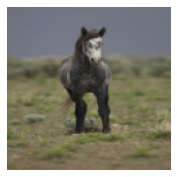

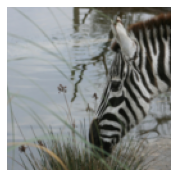

In [0]:
#----------------------------------------------------
# Load the data into a DataBundle
#----------------------------------------------------
icgdb = ImageCycleGanDataBundle(data_path, multi_path=['trainA', 'trainB'])
icgdb.do()

def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

foo=icgdb.train_ds.x[49]
show_image(foo[0]), show_image(foo[1])

### Training

In [0]:
  #----------------------------------------------------
  # Run end-to-end training
  #----------------------------------------------------
  def test_train(arch, test_data, loss_func, opt_func, lr, num_epochs=1):
    #arch = self.arch
    train_dl = test_data.train_dl
    valid_dl = test_data.valid_dl

    # Create two optimiser functions
    #   The primary one restricted to the Generator
    #   A secondary one restricted to the Discriminator
    g_param = list(arch.G_AB.parameters()) + list(arch.G_BA.parameters())
    d_param = list(arch.D_AB.parameters()) + list(arch.D_BA.parameters())
    opt_g = opt_func(g_param, lr=lr)
    opt_d = opt_func(d_param, lr=lr)
    opt = get_optimiser(arch, lr, opt_func, None)

    #callbs=[CudaCB(device = torch.device('cuda',0)), DiscriminatorCB(), ProgressCallback()]
    dtr = DebugTracker(freq=1, max_count=2)
    debug_cbs = [dtr, DebugYhatLossCB(bkwd=True)]
    callbs=[CudaCB(device = torch.device('cuda',0)), DiscriminatorCB(opt_d), ProgressCallback()] + [dtr]

    loop = Trainer(train_dl, valid_dl, arch, opt_g, loss_func, callbs, dtr)
    #loop.fit(num_epochs=num_epochs)
    return loop

In [0]:
def myfit(loop):
  db.set_trace()
  loop.fit(1)

#[n for n, m in loop.model.named_modules()]
#[n for n, m in loop.model.named_children()]
#[n for n, m in loop.model.named_parameters()]

app = ArchCycleGAN(ch_in=3, ch_out=3, n_features=64, n_disc=3, n_resnet=9)
loss = CycleGanLoss(app.arch)
loss_func = loss.generator_loss
#opt_func=adam_opt_func
opt_func=partial(optim.Adam, betas=(0.5,0.99))
#loop = test_train(app.arch, data, loss_func, opt_func, lr=1e-4, num_epochs=1)
loop = test_train(app.arch, icgdb, loss_func, opt_func, lr=1e-4, num_epochs=1)
loop.fit(num_epochs=1)
#myfit(loop)

In [0]:
dcdr = loop.dtr.get_results()
dcdrdf = pd.DataFrame(dcdr)
dcdrdf

,run_id,time,num_epochs,num_tr_batches,num_val_batches,batch_id,iter,batch_type,pred,loss,step_type,operation_type,data_item,param_mean,param_std,requires_grad,operation_idx,grad_mean,grad_std
0,Run-0,20200319_102659,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,0.041169,16.460051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,NaN,NaN,param,bkwd,D_AB.0.weight,-0.002456,0.200842,False,0.0,NaN,NaN
3,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,NaN,NaN,param,bkwd,D_AB.0.bias,0.000000,0.000000,False,0.0,NaN,NaN
4,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,NaN,NaN,param,bkwd,D_AB.2.weight,0.000102,0.044033,False,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bkf,G_BA.19.bias,-0.000259,0.015750,True,7.0,0.0,0.015750
927,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bkf,G_BA.22.weight,0.000154,0.024105,True,7.0,0.0,0.024105
928,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bkf,G_BA.22.bias,0.000295,0.021521,True,7.0,0.0,0.021521
929,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bkf,G_BA.26.weight,0.000232,0.010296,True,7.0,0.0,0.010296


In [0]:
dcdrdf[dcdrdf['data_item'] == 'G_BA.1.weight']

,run_id,time,num_epochs,num_tr_batches,num_val_batches,batch_id,iter,batch_type,pred,loss,step_type,operation_type,data_item,param_mean,param_std,requires_grad,operation_idx,grad_mean,grad_std
70,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,NaN,NaN,param,bkwd,G_BA.1.weight,-0.000527,0.117655,True,0.0,-0.002245,0.117655
186,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,NaN,NaN,param,bk1,G_BA.1.weight,-0.000523,0.117655,True,1.0,0.000000,0.117655
302,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,NaN,NaN,param,bk2,G_BA.1.weight,-0.000523,0.117655,True,2.0,0.000000,0.117655
418,Run-0,NaN,NaN,NaN,NaN,0.0,0.0,train,NaN,NaN,param,bkf,G_BA.1.weight,-0.000523,0.117655,True,3.0,0.000000,0.117655
535,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bkwd,G_BA.1.weight,-0.000523,0.117655,True,4.0,0.005747,0.117655
651,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bk1,G_BA.1.weight,-0.000531,0.117655,True,5.0,0.000000,0.117655
767,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bk2,G_BA.1.weight,-0.000531,0.117655,True,6.0,0.000000,0.117655
883,Run-0,NaN,NaN,NaN,NaN,0.1,1.0,train,NaN,NaN,param,bkf,G_BA.1.weight,-0.000531,0.117655,True,7.0,0.000000,0.117655


### Prediction

In [0]:
#----------------------------------------------------
# This cell is OBSOLETE
#----------------------------------------------------
def get_batch(filenames, tfms, **kwargs):
    samples = [open_image(fn) for fn in filenames]
    for s in samples: s = s.apply_tfms(tfms, **kwargs)
    batch = torch.stack([s.data for s in samples], 0).cuda()
    return 2. * (batch - 0.5)

tfms = get_transforms()[1]
bs = 1
fnames = data.train_ds.items[:8]
x = get_batch(fnames, get_transforms()[1], size=128)
fnames, x.shape, len(data.train_ds.items),len(data.train_ds.itemsB)

In [0]:
#----------------------------------------------------
# go through all the images of the training set and find the ones that are the best converted (according to our critics) or the worst converted.
#----------------------------------------------------

def get_losses(dl, fnames, gen, crit, bs=1):
    losses_out = []
    newiter = iter(dl)
    device = list(gen.parameters())[0].device
    with torch.no_grad():
        for i in progress_bar(range(0, len(fnames), bs)):
            #db.set_trace()
            #xb = get_batch(fnames[i:i+bs], tfms, size=128)
            newxb, _ = next(newiter)
            xb = newxb[0]
            xb = xb.to(device)
            fakes = gen(xb)
            preds_out = crit(fakes)
            #loss_in  = learn.loss_func.crit(preds_in, True,reduction='none')
            loss_out = F.mse_loss(preds_out, torch.zeros_like(preds_out), reduction='none')
            #losses_in.append(loss_in.view(loss_in.size(0),-1).mean(1))
            losses_out.append(loss_out.view(loss_out.size(0),-1).mean(1))
    return torch.cat(losses_out)

def show_best(img_tuples, losses, gen, n=8):
    sort_idx = losses.argsort()
    _,axs = plt.subplots(n//2, 4, figsize=(12,2*n))
    idxs = sort_idx.cpu()[:n]
    device = sort_idx.device
    for i, idx in enumerate(idxs):
      idx = idx.item()
      xb, _ = img_tuples[idx]
      xb = xb.unsqueeze(0).to(device)
      #db.set_trace()
      #xb = get_batch(fnm, tfms, size=128)
      with torch.no_grad():
        fake = gen(xb)
      
      #xb,fake = (1+xb)/2,(1+fake)/2

      axs.flatten()[2*i].imshow(xb[0].permute(1,2,0).cpu())
      axs.flatten()[2*i].axis('off')
      axs.flatten()[2*i+1].imshow(fake[0].permute(1,2,0).cpu())
      axs.flatten()[2*i+1].set_title(losses[idx].item())
      axs.flatten()[2*i+1].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


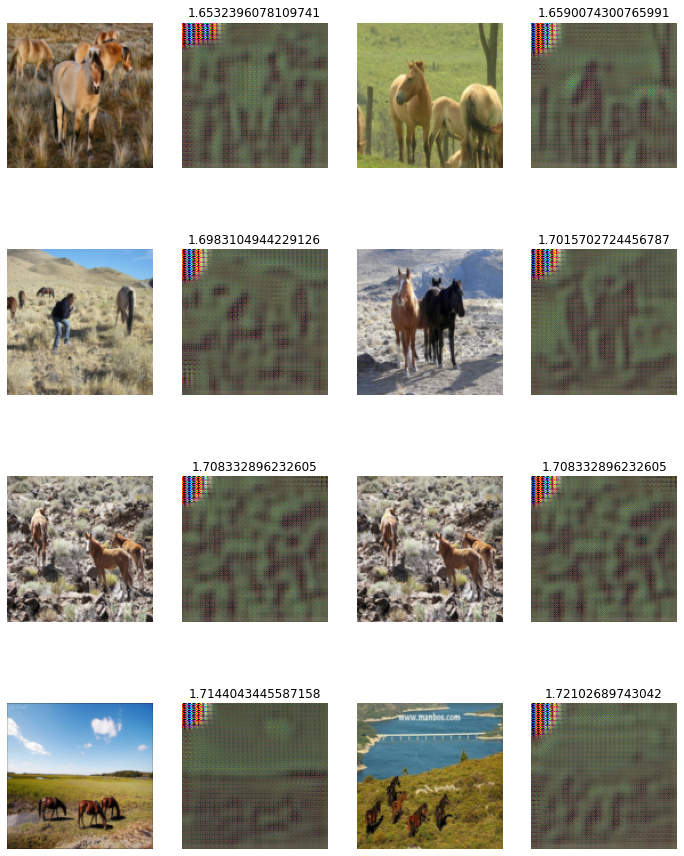

In [0]:
loop.model.eval()
losses_A = get_losses(icgdb.train_dl, icgdb.train_ds.x.items, loop.model.G_AB, loop.model.D_AB)
show_best(icgdb.train_ds.x, losses_A, loop.model.G_AB)

### Experiment

In [0]:
CycleGAN(
  (D_A): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (D_B): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
  (G_A): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (12): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (13): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (14): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (15): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (16): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (17): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (18): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (19): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (20): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (21): ReLU(inplace=True)
    (22): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (23): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (24): ReLU(inplace=True)
    (25): ReflectionPad2d((3, 3, 3, 3))
    (26): Conv2d(64, 3, kernel_size=(7, 7), stride=(1, 1))
    (27): Tanh()
  )
  (G_B): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (11): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (12): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (13): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (14): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (15): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (16): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (17): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (18): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
    )
    (19): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (20): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (21): ReLU(inplace=True)
    (22): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (23): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (24): ReLU(inplace=True)
    (25): ReflectionPad2d((3, 3, 3, 3))
    (26): Conv2d(64, 3, kernel_size=(7, 7), stride=(1, 1))
    (27): Tanh()
  )
)

In [0]:
class modl():
  def __init__(self):
    self.a = torch.tensor(5.0, requires_grad = True)

  def calc(self, inp):
    out = inp * self.a
    return (out)

# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0)
m = modl()
w = x * y + m.calc(torch.rand((1))[0])

z = w ** 2

v = w + x

z.backward(retain_graph=True)

# Displaying
for i, name in zip([x, y, m.a], "xya"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")
    
m.a.requires_grad_(False)
v.backward()

# Displaying
for i, name in zip([x, y, m.a], "xya"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")